#### 이번에는 Ray를 활용하면서 visualization하는 방법에 대해 알아보겠습니다. <br>

    1. Actor는 현재 노트북이 열린 pid와는 다른 pid에서 실행이 되므로, Actor안에서 노트북으로 바로 출력하기 어렵다.
    2. 따라서 Actor는 자신의 score 데이터를 다른 곳에 넘겨준다.
    3. 2번에서 넘겨준 데이터를 learner에서 plot한다(learner는 쥬피터 노트북 pid에서 실행이 되므로). 

In [6]:
import ray
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
ray.init() 

2021-01-29 13:50:27,969	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8267


{'node_ip_address': '192.168.0.61',
 'raylet_ip_address': '192.168.0.61',
 'redis_address': '192.168.0.61:58377',
 'object_store_address': '/tmp/ray/session_2021-01-29_13-50-27_211596_75357/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-29_13-50-27_211596_75357/sockets/raylet',
 'webui_url': '127.0.0.1:8267',
 'session_dir': '/tmp/ray/session_2021-01-29_13-50-27_211596_75357',
 'metrics_export_port': 63782,
 'node_id': '8bf5b09a04d83ada6c0df4860ec31c6fc185f402'}

In [3]:
@ray.remote
class Actor:
    def __init__(self, plot_inline):
        self.plot_inline = plot_inline

    def gen_data(self):
        for _ in range(100):
            score = np.random.randn() 
            actor_idx = np.random.randint(3)
            self.plot_inline.store_actor_data.remote(actor_idx, score) 

In [4]:
@ray.remote 
class Plot_inline:  
    def __init__(self): 
        self.score_dict = defaultdict(list) 
    
    def store_actor_data(self, actor_idx, score): 
        self.score_dict[actor_idx].append(score) 
        
    def store_learner_data(self, score): 
        self.score_dict['learner'].append(score) 

    def get_status(self, num_actors): 
        return self.score_dict 

In [5]:
class Learner:
    def __init__(self, plot_inline, num_actors): 
        self.num_actors = num_actors 
        self.plot_inline = plot_inline 

    def train(self):
        for _ in range(30):
            score = np.random.randn() 
            self.plot_inline.store_learner_data.remote(score)

    def plot_inline(self):  
        score_dict = ray.get(self.plot_inline.get_status.remote()) 
        clear_output(True)
        plt.figure(facecolor='w', figsize=(25,25)) 
        for idx in range(1, len(score_dict)):
            i,j = (idx-1)//5, (idx-1)%5 
            plt.subplot2grid((5,5), (i,j)) 
            plt.plot(score_dict[idx]) 
            plt.title(f"Score of Actor {idx}") 
        plt.subplot2grid((5,5), (4,4))
        plt.plot(score_dict['learner'])
        plt.show() 

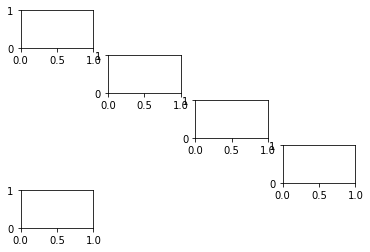

In [34]:
plt.figure(0)
ax1 = plt.subplot2grid((5,4), (0,0))
ax1.plot()
ax2 = plt.subplot2grid((5,4), (1,1))
ax3 = plt.subplot2grid((5,4), (2, 2))
ax4 = plt.subplot2grid((5,4), (3, 3))
ax5 = plt.subplot2grid((5,4), (4, 0))
plt.show()

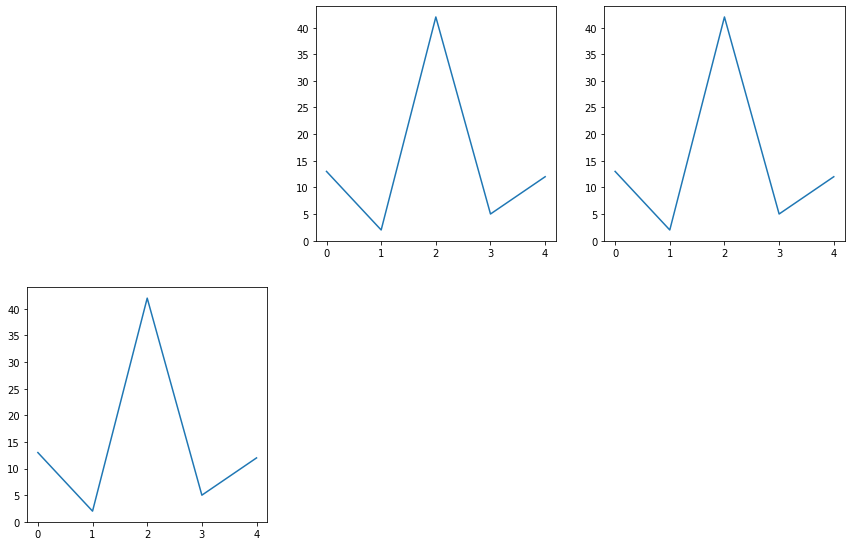

In [31]:
aa = '55'+str(1) 
plt.figure(facecolor='w', figsize=(25,25)) 
plt.subplot2grid((5,5), (1,0)) 
plt.plot([13,2,42,5,12])  
plt.subplot(552) 
plt.plot([13,2,42,5,12]) 
plt.subplot(553) 
plt.plot([13,2,42,5,12])  